We outline a structured approach for presenting research findings. The framework is divided into several key segments:

1. Introduction
1. Dataset overview
1. Analytics and learning strategies
1. Empirical resuts: baseline and robustness
1. Conclusion

The opening segment encompasses four essential elements:

- Contextual Background: What is the larger setting of the study? What makes this area of inquiry compelling? What are the existing gaps or limitations within the current body of research? What are some unanswered yet noteworthy questions?

- Project Contributions: What are the specific advancements made by this study, such as in data acquisition, algorithmic development, parameter adjustments, etc.?

- Summary of the main empirical results: What is the main statistical statement? is it significant (e.g. statistically or economically)?

- Literature and Resource Citations: What are related academic papers? What are the github repositories, expert blogs, or software packages that used in this project?

In the dataset profile, one should consider:

- The origin and composition of data utilized in the study. If the dataset is original, then provide the source code to ensure reproducibility.

- The chronological accuracy of the data points, verifying that the dates reflect the actual availability of information.

- A detailed analysis of descriptive statistics, with an emphasis on discussing the importance of the chosen graphs or metrics.

The analytics and machine learning methodologies section accounts for:

- A detailed explanation of the foundational algorithm.

- A description of the data partitioning strategy for training, validation and test.

- An overview of the parameter selection and optimization process.

To effectively convey the empirical findings, separate the baseline results from the additional robustness tests. Within the primary empirical outcomes portion, include:

- Key statistical evaluations (for instance, if presenting a backtest – provide a pnl graph alongside the Sharpe ratio).

- Insights into what primarily influences the results, such as specific characteristics or assets that significantly impact performance.

The robustness of empirical tests section should detail:

- Evaluation of the stability of the principal finding against variations in hyperparameters or algorithmic modifications.

Finally, the conclusive synthesis should recapitulate the primary findings, consider external elements that may influence the results, and hint at potential directions for further investigative work.


# Code writefiles


In [1]:
%pip install -U pandas numpy matplotlib pathlib seaborn requests lightgbm shap --break-system-packages

Note: you may need to restart the kernel to use updated packages.


In [2]:
%%writefile data_processing.py
"""
data_processing.py

Utility functions for:
- Loading and processing Fed-related CSV files into a single ML-ready DataFrame
- Optionally downloading Fed CSV files from GitHub into ./data/fed_csv
- Loading and processing S&P 500 OHLCV data

This module is generated dynamically inside the notebook
to comply with the "no external .py files" requirement.
"""

import os
import glob
import re
from pathlib import Path

import pandas as pd
import numpy as np
import requests
import yfinance as yf


# ---------------------------------------------------------------------
# S&P 500 loader
# ---------------------------------------------------------------------

def load_sp500_data(
    ticker: str = "^GSPC",
    start: str = "2023-09-07",
    end: str = None,
    output_path: str = "data//sp500/sp500_ohlcv_returns.csv",
) -> pd.DataFrame:
    """
    Download, process, and save S&P 500 OHLCV and derived metrics.

    Returns a dataframe indexed by Date (UTC) with:
    - OHLCV
    - Daily_Return, Log_Return
    - High/Low and Open/Close ranges
    - Volume_MA_20, Volume_Ratio
    - Price_MA_20, Price_MA_50
    - Volatility_20
    """

    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    spx = yf.download(
        ticker,
        start=start,
        end=end,
        progress=False,
        auto_adjust=True,
    )

    if spx.empty:
        raise RuntimeError(f"No data returned for {ticker} from Yahoo Finance.")

    # Flatten multi-index columns if present
    if isinstance(spx.columns, pd.MultiIndex):
        spx.columns = spx.columns.get_level_values(0)

    spx["Daily_Return"] = spx["Close"].pct_change()
    
    cols_to_keep = ["Daily_Return", "Open", "Close"]

    available = [c for c in cols_to_keep if c in spx.columns]

    daily = spx[available].dropna().copy()
    daily.index.name = "Date (UTC)"

    daily.to_csv(output_path)

    return daily

Overwriting data_processing.py


In [3]:
%%writefile polymarket_api.py
"""
polymarket_api.py

Utility functions for:
- Extracting timeseries data for each market belong to a keyword on Polymarket

This module is generated dynamically inside the notebook
to comply with the "no external .py files" requirement.
"""
import pandas as pd
import numpy as np
import os
from datetime import datetime
import datetime as dt
import requests
import json
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

def get_token_ids(keyword: str):
    url = "https://gamma-api.polymarket.com/events"
    params = {"limit": 1000, "tag_id": keyword}
    data = requests.get(url, params=params).json()
    markets = data.get("data", []) if isinstance(data, dict) else data
    tokens = []
    for m in markets:
        markets = m["markets"]
        for i in markets:
            try:
                start_value = i["startDate"]
            except KeyError:
                start_value = i.get("acceptingOrdersTimestamp")

            try:
                end_value = i["endDate"]
            except KeyError:
                end_value = i.get("closedTime")
            try:
                clobs = (
                    json.loads(i["clobTokenIds"])
                    if isinstance(i["clobTokenIds"], str)
                    else i["clobTokenIds"]
                )
                tokens.append(
                    {
                        "market_id": i["id"],
                        "slug": i["slug"],
                        "startDate": start_value,
                        "endDate": end_value,
                        "clobTokenIds": clobs[0],
                    }
                )
            except KeyError:
                #print(i)
                continue
    return tokens

def get_polymarket_timeseries(
    df_events,
):
    base_url = "https://clob.polymarket.com/prices-history"
    interval = "max"
    fidelity = 60
    dfs = []
    for i in range(len(df_events)):
        token_id = df_events.iloc[i]["clobTokenIds"]
        name = df_events.iloc[i]["slug"]
        params = {
            "market": token_id,
            "startTs": 1,
            "interval": interval,
            "fidelity": fidelity,
        }
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            data = response.json()["history"]
            df = pd.DataFrame(data)
            df['timestamp'] = pd.to_datetime(df['t'], unit='s')
            df[f"{name}"] = df['p']
            df = df[['timestamp', f"{name}"]].sort_values('timestamp')
            df_10h = df[df['timestamp'].dt.hour == 12].reset_index(drop=True)
            df_10h['timestamp'] = df_10h[
                'timestamp'
            ].dt.normalize()  # remove time → midnight
            dfs.append(df_10h.iloc[1:].reset_index(drop=True))
        except Exception:
            print(name)
            continue
    return dfs

def push_dfs_to_csv(
    dfs
):
    for df_10h in dfs:
        name = df_10h.columns[1]  # "slug"
        out_path = DATA_DIR / f"{name}.csv"
        df_10h.to_csv(out_path, index=False)
        print("Saved:", out_path)


def get_polymarket_timeseries_data(token_ids: list, load_from_api: bool=True):
    if not load_from_api:
        dfs = []
        for csv_path in DATA_DIR.glob("*.csv"):
            try:
                df = pd.read_csv(csv_path, parse_dates=["timestamp"])
                dfs.append(df)
            except Exception as e:
                print(f"Failed to load {csv_path}: {e}")

        print(f"Loaded {len(dfs)} dataframes from CSV.")
    else:
        fed_events_l = []
        for i in token_ids:
            fed_events = get_token_ids(i)
            fed_events_l.append(pd.DataFrame(fed_events))

        df_events =  pd.concat(fed_events_l, ignore_index=True)
        df_events = df_events.drop_duplicates(subset=["clobTokenIds"])

        dfs = get_polymarket_timeseries(df_events)
        dfs = [d for d in dfs if len(d) >= 10]
        push_dfs_to_csv(dfs)
    return dfs


def create_big_timeseries_dataset(dfs):
    cleaned = []

    for d in dfs:
        d = d.copy()
        d["timestamp"] = pd.to_datetime(d["timestamp"], errors="coerce")

        # keep last occurrence per timestamp (or use keep="first")
        d = d.drop_duplicates(subset="timestamp", keep="last")

        d = d.set_index("timestamp")
        cleaned.append(d)

    combined = pd.concat(cleaned, axis=1).sort_index().reset_index()
    # bounds (at midnight)
    start_day = combined["timestamp"].min().floor("D")
    end_day = combined["timestamp"].max().floor("D")

    # daily index and DataFrame
    daily_index = pd.date_range(start=start_day, end=end_day, freq="D", tz="UTC")
    days_df = pd.DataFrame({"timestamp": daily_index})
    days_df['timestamp'] = pd.to_datetime(days_df['timestamp'], utc=True).dt.date

    combined["timestamp"] = pd.to_datetime(combined["timestamp"], utc=True).dt.date
    days_df["timestamp"] = pd.to_datetime(days_df["timestamp"], utc=True).dt.date
    merged_df = days_df.merge(combined, on='timestamp', how='left')
    return merged_df


Overwriting polymarket_api.py


In [4]:
%%writefile trading.py

"""
trading.py

Utility functions for:


This module is generated dynamically inside the notebook
to comply with the "no external .py files" requirement.
"""

import pandas
import numpy as np
import matplotlib.pyplot as plt

"""
trading.py

Small utility helpers used by the notebooks:

- `split`: Create train/test index splits by fraction, preserving order.
- `sharpe`: Compute annualized Sharpe ratio from a return series.
- `backtest_slice`: Turn a trading signal into strategy returns and a
  cumulative return curve over a given index slice.

Notes
-----
This module can be generated dynamically inside a notebook to comply with
"no external .py files" constraints. The functions are intentionally minimal
and avoid side effects so they can be reused across experiments.
"""

def split(df, frac=0.8):
    """Return train/test index splits by fraction, preserving order.

    Parameters
    - df: DataFrame whose index defines the timeline to split.
    - frac: Fraction of samples allocated to the train split (0..1).

    Returns
    - (train_idx, test_idx): Tuple of index slices referencing ``df``.

    Notes
    - No shuffling is performed; suitable for time series where order matters.
    """
    df = df
    split = int(len(df) * frac)
    train_idx = df.index[:split]
    test_idx  = df.index[split:]
    return train_idx, test_idx

def sharpe(series):
    """Annualized Sharpe ratio (daily sampling assumed).

    Parameters
    - series: Return series (e.g., daily strategy returns).

    Returns
    - float Sharpe ratio scaled by ``sqrt(252)``. Returns ``NaN`` if empty.

    Notes
    - Adds a small epsilon in the denominator to avoid division by zero.
    - If your sampling frequency differs, change the scaling factor.
    """
    s = series.dropna()
    return (np.sqrt(252) * s.mean() / (s.std() + 1e-12)) if len(s) else np.nan

# Backtest helper
def backtest_slice(df, idx, sig_series_or_name, ret_col='Daily_Return'):
    """Compute strategy and cumulative returns over a slice of ``df``.

    Parameters
    - df: DataFrame containing at least the return column ``ret_col``.
    - idx: Index or index-like selector defining the evaluation slice.
    - sig_series_or_name: Either the name of a column in ``df`` or an
      external Series aligned to ``df.index`` that encodes the trading
      signal (e.g., -1/0/1 or fractional exposure).
    - ret_col: Name of the per-period return column in ``df``.

    Returns
    - r: Series of per-period strategy returns on ``idx``.
    - cum: Series of cumulative returns (starting at 1.0) on ``idx``.

    Important
    - Ensure your signal does not leak future information. If the signal
      is computed from same-day data, consider shifting it by one period
      before backtesting to avoid look-ahead bias.
    - Missing signal values are propagated into ``r``; for the cumulative
      curve they are treated as zero return for that period.
    Example
    -------
    # Avoid look-ahead by acting next period
    sig_safe = df['signal_markov_oos'].shift(1)
    r, cum = backtest_slice(df, idx=test_idx, sig_series_or_name=sig_safe)
    """
    # Resolve the signal series from a column name or an external Series
    if isinstance(sig_series_or_name, str):
        signal = df.loc[idx, sig_series_or_name]
    else:
        signal = sig_series_or_name.loc[idx]

    # Underlying per-period returns from the dataframe
    asset_returns = df.loc[idx, ret_col]

    # Per-period strategy returns: position × underlying returns
    strategy_returns = signal.astype(float) * asset_returns

    # Cumulative return curve (1.0 baseline). NaNs treated as 0 return.
    cumulative = (1 + strategy_returns.fillna(0)).cumprod()

    return strategy_returns, cumulative



Overwriting trading.py


# Introduction

In this project on Machine Learning for Portfolio Management and Trading, we investigate the effect of central bank policies on financial markets. Our approach focuses on betting activity related to Federal Reserve decisions and monetary policy related topics, aiming to study whether this information can be transformed into a tradable strategy. The data is sourced from Polymarket, a decentralized prediction market platform where users anonymously place bets on real-world events, including Federal Reserve policy outcomes.

By analyzing the evolution of these betting probabilities, especially in the hours leading up to market open, we seek to detect shifts in sentiment or positioning that may precede movements in the S&P 500. In particular, sudden changes in betting activity before scheduled announcements could indicate meaningful information flow, whether due to collective expectations, rapid consensus formation, or, in rare cases, the presence of informed traders operating in an anonymous and decentralized environment. Our goal is to determine whether such early signals contain predictive value and whether they can be systematically incorporated into a daily trading strategy.


### Contextual Background

Markets, and our reference index the S&P 500, are highly affected by the monetary policies of central banks, particularly the Federal Reserve. Much research has examined how monetary policy decisions shape market activity. In general, unexpected changes in expectations about Fed policy are associated with sharp increases in volatility and large market moves, while pre-scheduled FOMC announcements tend to allow markets to price interest-rate risk more efficiently. In this paper, we highlight episodes of market behavior that coincide with unexpected policy-related events and show how these patterns appear in the daily returns of the S&P 500. These observations build on established evidence that equity markets react strongly to monetary policy surprises as described in Bernanke, B. & Kuttner, K. (2004).

[1]: Bernanke, B. & Kuttner, K. (2004). _What Explains the Stock Market’s Reaction to Federal Reserve Policy?_

---

### Prediction Markets and Informational Efficiency

A second motivation for using Polymarket comes from the fact that prediction markets often react quickly to new information and can aggregate expectations better than surveys or expert opinions. Wolfers and Zitzewitz (2006) show that prediction-market prices usually adjust ahead of major events and can reflect both public expectations and, at times, the actions of better-informed traders.

Based on this idea, we look at whether Polymarket, because it is decentralized, anonymous, and trades 24/7. Since it has low barriers to participation and updates continuously, it gives us a high-frequency view of expectations around monetary-policy decisions. If betting probabilities move before the equity market opens or ahead of FOMC announcements, these shifts may reflect changes in sentiment, early positioning, or even informed trading. This allows us to check whether these signals help predict next-day S&P 500 returns.

[2]: Wolfers, J. & Zitzewitz, E. (2006). _Prediction Markets in Theory and Practice._

---

### Project Contributions

Our study contributes in a few ways. First, to the best of our knowledge, nobody has used Polymarket data to study possible anticipation effects on the S&P 500 or to build a trading strategy from it. So the idea of linking decentralized prediction-market data with equity-index returns is new.

Second, we built our own dataset by collecting all the relevant Polymarket markets through their API and cleaning the data ourselves. Third, on the machine-learning side, we use LightGBM, which works well with noisy and unstructured features like ours and can capture non-linear relationships. We explain this more in the model section of the notebook.

Taken together, these points allow us to test whether Polymarket signals contain information that can help forecast next-day S&P 500 returns.

---


### Summary of the main empirical results

What is the main statistical statement? is it significant (e.g. statistically or economically)?

Our proposed approach of using gradiend boosting methods to analyze the unstructred dataset of Polymarket have led to promising results. It appears that feeding the unstructred data, without any preprocessing, into a rolling LightGBM model leads to a profitable startegy with a sharpe ratio of 2.2 which is able to beat a simple buy and hold startegy on the same time horizon.

After polishing the dataset, by adding an indicator which acts as a proxy of volume and market sentiment, along with transforming the input feature matrix through rolling means and normalization the performance has further increase, and the developed strategy achieved a sharpe ratio 0f 6. Such results seems to good to be true...


### Literature and Resource Citations

What are related academic papers? What are the github repositories, expert blogs, or software packages that used in this project?

Throughout the development of the project, we have taken and adapted several code portions developed in the `skfin` code repository available on GitHub and developed by Prof. Sylvain Champonnois. Available at: https://github.com/schampon/skfin

Besides standard packages for plotting, data and numerical manipulation, we have used `sklearn` which provides acess to many estimators and models such as `LightGBM`


# Dataset Overview


### What is Polymarket?

The dataset is built from Polymarket, the world’s largest prediction market where users bet on future events through binary markets. Polymarket is organised into events (groupings of related questions) and markets, each containing a Yes and No contract priced between 1 and 100 cents in USDC. These prices represent the implied probability of an outcome occurring and are determined by users trading against each other; Polymarket itself only takes a 0.5% fee on profitable trades. Prediction markets operate under the Efficient Market Hypothesis, meaning prices quickly incorporate public information and reflect collective beliefs. To construct the dataset, we pulled all markets tagged “Fed” and “Fed Rates,” capturing questions on rate cuts, hikes, and target levels. The data therefore reflects a wide set of markets tied to the same underlying macro event, and as a result, the markets are highly correlated since traders update their expectations simultaneously across all Fed-related outcomes.

---

### What is a prediction market?

Wolfers & Zitzewitz (2004) describe prediction markets as a straightforward way to aggregate dispersed information into a single probability about a future event. Traders buy or sell contracts that pay off depending on the outcome, and the price that emerges reflects the market’s collective view of the likelihood. Their evidence shows that these markets often outperform traditional forecasting methods, especially in areas like elections, because prices adjust quickly as informed traders bring new information. This mechanism ties directly to the Efficient Market Hypothesis: as traders act on their beliefs, the market price incorporates information in real time. The authors also stress that good market design matters: clear contract definitions, enough liquidity, reliable resolution rules, and consistent interpretation of outcomes all play a role in ensuring accurate and robust forecasts.

[2]: Wolfers, J. & Zitzewitz, E. (2004). Prediction Markets in Theory and Practice. https://pubs.aeaweb.org/doi/pdfplus/10.1257/0895330041371321

---

### How does Polymarket work?

Polymarket is structured around two layers: _events_ and _markets_.  
An event groups together multiple related questions (for example, all markets tied to the same FOMC meeting). Within each event, individual markets represent specific binary questions with two possible outcomes: _Yes_ or _No_. Each market trades like a simple contract that pays out $1 if the outcome happens and $0 if it does not. Traders can buy Yes or No at any price between 0 and 1 USD (in USDC), and the price reflects the market’s implied probability of that outcome.

A trade happens when a buyer and seller agree on a price—if you buy Yes at 0.30 USD, another trader is effectively buying No at 0.70 USD. Polymarket does not take the other side of the trade; it only provides the platform and takes no fees [3]. Prices move based on supply and demand, meaning the market continuously updates as traders incorporate new information. This structure allows Polymarket to aggregate beliefs efficiently: the current price is the crowd’s real-time estimate of the probability that the event resolves in favour of Yes.

[3]: https://docs.polymarket.com/polymarket-learn/trading/fees

### Events

An _event_ is a grouping of related markets.  
Example: https://polymarket.com/event/fed-decision-in-december?tid=1763131450437

### Markets

A _market_ is a single binary question with a Yes/No outcome.  
Each market resolves to either 1 USD (if Yes happens) or 0 USD (if it does not).  
Example: https://polymarket.com/event/fed-decision-in-december/fed-decreases-interest-rates-by-50-bps-after-december-2025-meeting?tid=1763153945743

---

## Prices as probabilities

•⁠ ⁠Prices are probabilities.
•⁠ ⁠Each contract is worth between _1 and 100 cents_ in _USDC_ (a US dollar–pegged stablecoin).

### Walk-through example

Say for the event of the Fed decision in December:

•⁠ ⁠If I believe that there is a _30% probability_ there will be _no rate cut_,  
 I can place a bid for _30 cents_ on _Yes_.
•⁠ ⁠When another user is willing to buy the counterpart _No_ with implied _70% probability_ (70 cents),  
 the contract is created.

The open bids for _Yes_ and _No_ are not equal; there is a _spread_.  
If not, the contracts are not resolved (no trade).  
This reflects people’s beliefs to only buy the contract at the price they consider fair.

---

### How did we pull the data?

Each Polymarket market is associated with one or more _tags, and each tag has its own numeric identifier. We identified the tags relevant to monetary policy, specifically _“Fed Rates”_ and _“Fed”_, and used these tag IDs to retrieve all markets linked to them. For every market, we extracted the token ID corresponding to the \*\*Yes_ outcome, since each outcome (Yes/No) is represented by a separate token on-chain. Using these token IDs, we then requested the full historical time series for each token, which provides the price evolution and liquidity over time for all Fed-related markets.


In [5]:
# imports
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from polymarket_api import get_polymarket_timeseries_data, create_big_timeseries_dataset

dfs = get_polymarket_timeseries_data([100196, 159], load_from_api=True)

poly_df = create_big_timeseries_dataset(dfs)

will-trump-announce-person-a-as-next-fed-chair
will-trump-announce-person-f-as-next-fed-chair
will-trump-announce-person-b-as-next-fed-chair
will-trump-announce-person-c-as-next-fed-chair
will-trump-announce-person-d-as-next-fed-chair
will-trump-announce-person-e-as-next-fed-chair
will-trump-announce-person-g-as-next-fed-chair
will-trump-announce-someone-else-as-next-fed-chair
will-trump-announce-person-h-as-next-fed-chair-in-2025
will-trump-announce-person-i-as-next-fed-chair-in-2025
will-trump-announce-someone-else-as-next-fed-chair-in-2025
will-trump-nominate-individual-t-as-the-next-fed-chair
will-trump-nominate-individual-m-as-the-next-fed-chair
will-trump-nominate-individual-o-as-the-next-fed-chair
will-trump-nominate-individual-p-as-the-next-fed-chair
will-trump-nominate-individual-q-as-the-next-fed-chair
will-trump-nominate-individual-r-as-the-next-fed-chair
will-trump-nominate-individual-s-as-the-next-fed-chair
will-trump-nominate-individual-u-as-the-next-fed-chair
will-trump-

### Plot of Dataframe Lengths

In our dataset we pull all Fed-related Polymarket bets. Some bets run for a long time while others finish almost immediately. To get a clearer idea of how these markets behave, we plot their lengths below. After some cleaning, we also show how many markets are active at each point in time.

This helps us see what happens around major news events. For example, on **October 29th**, when the Fed decided to cut rates by 25 bps, many of the related markets suddenly resolved as the policy outcome became known:

Federal Reserve Board. (2025, October 29). _Federal Reserve issues FOMC statement_. https://www.federalreserve.gov/newsevents/pressreleases/monetary20251029a.htm


428
lengths: [27, 27, 27, 27, 34, 236, 41, 41, 41, 41, 28, 48, 48, 48, 48, 54, 54, 54, 54, 150, 96, 49, 96, 96, 96, 96, 43, 25, 133, 133, 133, 133, 133, 90, 172, 82, 82, 82, 82, 82, 11, 32, 32, 32, 32, 32, 32, 32, 32, 32, 201, 201, 201, 201, 201, 201, 90, 90, 90, 90, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 318, 261, 318, 302, 318, 318, 318, 318, 318, 318, 183, 318, 103, 103, 103, 103, 287, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 131, 131, 131, 131, 232, 260, 260, 260, 260, 26, 26, 26, 26, 11, 195, 252, 132, 132, 132, 132, 42, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 47, 71, 52, 21, 21, 21, 21, 21, 21, 21, 21, 35, 218, 218, 218, 218, 218, 218, 218, 48, 48, 48, 48, 208, 208, 208, 208, 208, 208, 208, 155, 155, 155, 145, 141, 121, 208, 132, 132, 132, 132, 44, 44, 44, 44, 130, 130, 130, 131, 14, 63, 63, 63, 46, 14, 45, 14, 40, 114, 48, 48, 48, 48, 104, 104, 104, 104, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 96, 96, 96, 96, 91, 91, 91

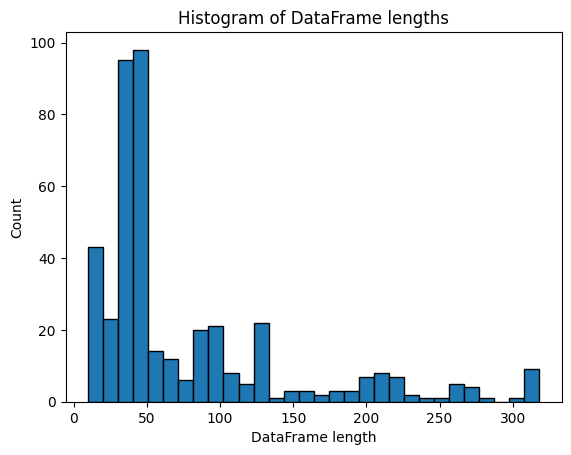

In [7]:
lengths = [len(d) for d in dfs]
shortest_i = min(range(len(dfs)), key=lambda i: lengths[i])
longest_i = max(range(len(dfs)), key=lambda i: lengths[i])

print(len(dfs))
print("lengths:", lengths)
print("shortest index:", shortest_i, "len:", lengths[shortest_i])
print("longest index:", longest_i, "len:", lengths[longest_i])

plt.hist(lengths, bins=30, edgecolor='k')
plt.xlabel('DataFrame length')
plt.ylabel('Count')
plt.title('Histogram of DataFrame lengths')
plt.show()

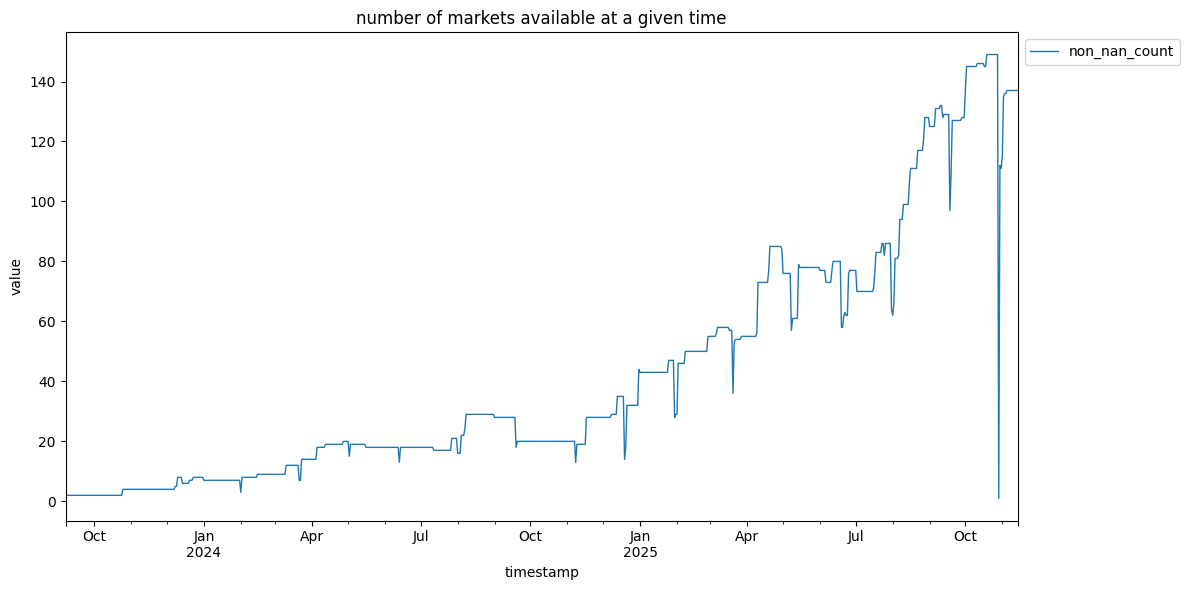

In [8]:
df_plot = poly_df[["timestamp"]].copy()
df_plot["non_nan_count"] = poly_df.notna().sum(axis=1)
df_plot["timestamp"] = pd.to_datetime(df_plot["timestamp"], utc=True)
df_plot = df_plot.set_index("timestamp")

ax = df_plot.plot(figsize=(12, 6), linewidth=1)
ax.set_xlabel("timestamp")
ax.set_ylabel("value")
ax.legend(
    loc="upper left", bbox_to_anchor=(1, 1)
)  # move legend outside if many columns
plt.title("number of markets available at a given time")
plt.tight_layout()
plt.show()

In [9]:
df_plot.tail(20)

,non_nan_count
timestamp,
2025-10-26 00:00:00+00:00,149
2025-10-27 00:00:00+00:00,149
2025-10-28 00:00:00+00:00,149
2025-10-29 00:00:00+00:00,1
2025-10-30 00:00:00+00:00,112
2025-10-31 00:00:00+00:00,111
2025-11-01 00:00:00+00:00,115
2025-11-02 00:00:00+00:00,135
2025-11-03 00:00:00+00:00,136


### Convergence of all markets

Below we plot all markets against time, it can be observed that they all gradually converge to 0 or 1 as their outcome is resolved. Note that several bets move together due to their high correlation.


/var/folders/v0/5yh69m_x5wjc7sbzxnlsgyt40000gn/T/ipykernel_74011/2413310906.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


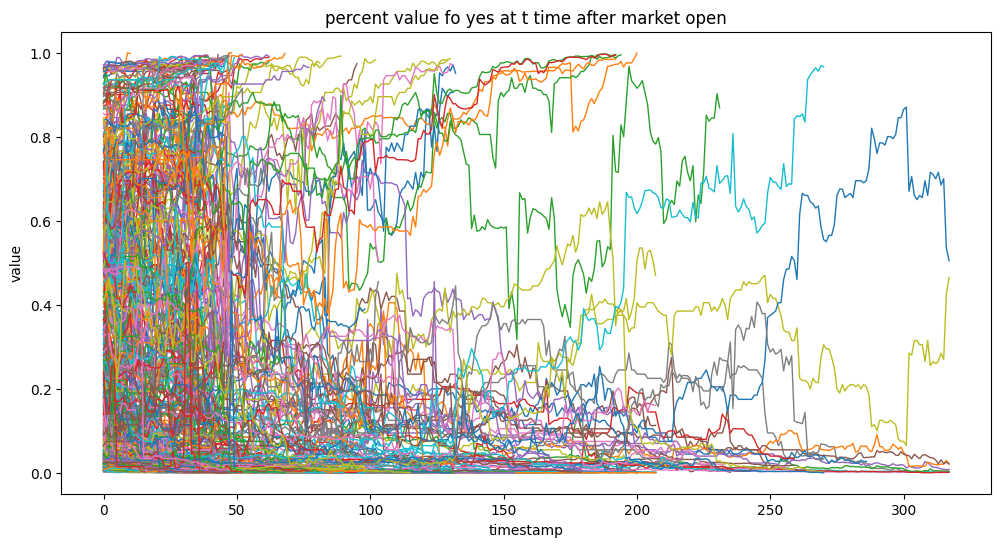

In [10]:
df_plot = pd.concat([d.drop(["timestamp"], axis=1) for d in dfs])


ax = df_plot.plot(figsize=(12, 6), linewidth=1)
ax.set_xlabel("timestamp")
ax.set_ylabel("value")
plt.title("percent value fo yes at t time after market open")
plt.tight_layout()
plt.legend().remove()
plt.show()

### Merging Polymarket data with S&P daily data


In [11]:
from data_processing import load_sp500_data

spx = load_sp500_data()
spx = spx[spx.index >= "2023-09-07"]
spx.head()

Price,Daily_Return,Open,Close
Date (UTC),,,
2023-09-08,0.001427,4451.299805,4457.490234
2023-09-11,0.006723,4480.979980,4487.459961
2023-09-12,-0.005696,4473.270020,4461.899902
2023-09-13,0.001242,4462.649902,4467.439941
2023-09-14,0.008430,4487.779785,4505.100098


In [12]:
fed_df = poly_df.copy(deep=True)
fed_df = fed_df.rename(columns={'timestamp': 'Date'})

In [13]:
# Ensure consistent Date column
if isinstance(spx.index, pd.DatetimeIndex) or spx.index.name:
    spx = spx.reset_index()

if 'Date (UTC)' in spx.columns:
    spx = spx.rename(columns={'Date (UTC)': 'Date'})
elif 'Date' not in spx.columns:
    raise ValueError("spx has no Date/Date (UTC) column")

if 'Date' not in fed_df.columns and isinstance(fed_df.index, pd.DatetimeIndex):
    fed_df = fed_df.reset_index().rename(columns={'index': 'Date'})

spx['Date'] = pd.to_datetime(spx['Date'])
fed_df['Date'] = pd.to_datetime(fed_df['Date'])

start_date = pd.to_datetime(fed_df['Date'].min())

merged_fed_sp_df = (
    pd.merge(spx, fed_df, on='Date', how='left', sort=True)
    .query('Date >= @start_date')
    .sort_values('Date')
    .reset_index(drop=True)
)


merged_fed_sp_df.head()

,Date,Daily_Return,Open,Close,will-the-fed-raise-interest-rates-by-25-bps-after-its-2024-aprilmay-meeting,no-change-in-fed-raise-interest-rates-after-its-2024-aprilmay-meeting,will-the-fed-decrease-interest-rates-by-25-bps-after-its-2024-aprilmay-meeting,will-the-fed-decrease-interest-rates-by-50-bps-after-its-aprilmay-2024-meeting,us-inflation-0pt3-from-march-to-april-2024,fed-rate-hike-in-2024,...,will-the-fed-raise-rates-again-in-2023,will-the-fed-raise-interest-rates-by-0-bps-after-its-december-meeting,will-the-fed-raise-interest-rates-by-25-bps-after-its-december-meeting,will-the-fed-raise-interest-rates-by-0-bps-after-its-january-meeting,will-the-fed-decrease-interest-rates-by-25-bps-after-its-january-meeting,will-the-fed-raise-interest-rates-by-25-bps-after-its-january-meeting,will-the-fed-raise-interest-rates-by-25-bps-after-its-2024-march-meeting,will-the-fed-decrease-interest-rates-by-50-bps-after-its-march-2024-meeting,will-the-fed-decrease-interest-rates-by-25-bps-after-its-2024-march-meeting,no-change-in-fed-raise-interest-rates-after-its-2024-march-meeting
0,2023-09-08,0.001427,4451.299805,4457.490234,NaN,NaN,NaN,NaN,NaN,NaN,...,0.430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-09-11,0.006723,4480.979980,4487.459961,NaN,NaN,NaN,NaN,NaN,NaN,...,0.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-09-12,-0.005696,4473.270020,4461.899902,NaN,NaN,NaN,NaN,NaN,NaN,...,0.215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-09-13,0.001242,4462.649902,4467.439941,NaN,NaN,NaN,NaN,NaN,NaN,...,0.280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-09-14,0.008430,4487.779785,4505.100098,NaN,NaN,NaN,NaN,NaN,NaN,...,0.410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analytics and learning

For our predictive analysis we rely on Gradient Boosting Machines (GBM) desscribed in Ke, G. et al. (2017), a family of models that build many small decision trees in sequence, with each new tree correcting the errors of the previous ones. This iterative process allows the model to capture complex, nonlinear relationships without requiring strong assumptions about how the data is generated. We implement this approach using LightGBM, an efficient and highly optimized GBM framework that uses histogram-based binning and leaf-wise tree growth to achieve high accuracy with very fast training times.

LightGBM is particularly well suited to our setting because the inputs we use—market-derived signals, Polymarket probabilities, and event-driven return patterns—are irregular, noisy, and only partially structured. Traditional linear or parametric models struggle with this type of data, as they rely on smooth relationships and stationarity. In contrast, LightGBM naturally handles discontinuities, threshold effects, nonlinearities, missing values, and interactions between features without extensive preprocessing. These properties make it an effective tool for identifying how unexpected monetary-policy-related events propagate into the daily returns of the S&P 500.

---

### Applying LightGBM to S&P Returns

In addition, we implement our model within a rolling training framework. Since Polymarket contracts typically remain active for an average of around 45 days, we assume that the predictive structure of the data evolves over similar horizons. To account for this, we retrain the model every day using all information until the day before the returns we are trying to predict: on each date we fit LightGBM on the most recent data, generate a prediction for the next day’s S&P 500 return, and then roll the window forward by one day. This approach allows the model to continuously adapt to changing market conditions, shifting expectations about monetary policy, and evolving patterns in prediction-market pricing.

Since Polymarket is a relatively new platform, most of its trading activity and market depth have increased only within the past year. For this reason, we adopt an 80/20 chronological split, where the initial 80% of observations are used for model initialization and parameter calibration, and the remaining 20% aligns with the period of elevated volume and richer informational content. After training on the initial 80%, we then apply the previously described rolling-window strategy on the final portion of the dataset. This approach also improves computational efficiency, as the number of trees constructed for each timestamp is reduced to the length of the last portion of the test set.

This methodology is particularly appropriate for S&P 500 returns because equity index returns are well known to exhibit low long-term predictability, rapidly shifting regimes, and short-lived signals driven by macro announcements and policy surprises. Most of the information in daily stock-index movements is influenced by immediate news flow and sentiment rather than persistent structural factors, meaning that models benefit from frequent retraining and a focus on the most recent market environment. A rolling approach captures these dynamics by continually updating the model’s understanding of how current prediction-market probabilities and monetary-policy expectations translate into next-day index returns.

[3]: Ke, G. et al. (2017). _LightGBM: A Highly Efficient Gradient Boosting Decision Tree_.


# Empirical resuts: baseline and robustness

Following the LightGBM rolling startegy, we were able to obtain the predict return for the next trading day, we transform such return into a binary outcome, specifically we assign a value of +1 to positive returns and -1 to negatives ones. Then we position ourselves on the market long or short at market open based on the signal and we close all positions at the close of the day. The cumulative returns of our strategy lead to the PNL graphs plotted below.

In our analysis we don't take into account transaction cost which would negatively impact the performance of our trading strategy. Transaction cost include, brokerage fee, splippage and market impact ans should be investigated to implement this strategy in a production setting.


### Baseline Buy and Hold strategy

Before delving into the machine learning approach we propose a benchmark strategy of buy and hold


### Rolling LGBM


In [14]:
merged_fed_sp_df

,Date,Daily_Return,Open,Close,will-the-fed-raise-interest-rates-by-25-bps-after-its-2024-aprilmay-meeting,no-change-in-fed-raise-interest-rates-after-its-2024-aprilmay-meeting,will-the-fed-decrease-interest-rates-by-25-bps-after-its-2024-aprilmay-meeting,will-the-fed-decrease-interest-rates-by-50-bps-after-its-aprilmay-2024-meeting,us-inflation-0pt3-from-march-to-april-2024,fed-rate-hike-in-2024,...,will-the-fed-raise-rates-again-in-2023,will-the-fed-raise-interest-rates-by-0-bps-after-its-december-meeting,will-the-fed-raise-interest-rates-by-25-bps-after-its-december-meeting,will-the-fed-raise-interest-rates-by-0-bps-after-its-january-meeting,will-the-fed-decrease-interest-rates-by-25-bps-after-its-january-meeting,will-the-fed-raise-interest-rates-by-25-bps-after-its-january-meeting,will-the-fed-raise-interest-rates-by-25-bps-after-its-2024-march-meeting,will-the-fed-decrease-interest-rates-by-50-bps-after-its-march-2024-meeting,will-the-fed-decrease-interest-rates-by-25-bps-after-its-2024-march-meeting,no-change-in-fed-raise-interest-rates-after-its-2024-march-meeting
0,2023-09-08,0.001427,4451.299805,4457.490234,NaN,NaN,NaN,NaN,NaN,NaN,...,0.430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-09-11,0.006723,4480.979980,4487.459961,NaN,NaN,NaN,NaN,NaN,NaN,...,0.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-09-12,-0.005696,4473.270020,4461.899902,NaN,NaN,NaN,NaN,NaN,NaN,...,0.215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-09-13,0.001242,4462.649902,4467.439941,NaN,NaN,NaN,NaN,NaN,NaN,...,0.280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-09-14,0.008430,4487.779785,4505.100098,NaN,NaN,NaN,NaN,NaN,NaN,...,0.410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2025-11-07,0.001262,6696.180176,6728.799805,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
545,2025-11-10,0.015401,6785.359863,6832.430176,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,2025-11-11,0.002075,6815.640137,6846.609863,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
547,2025-11-12,0.000630,6867.770020,6850.919922,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
test_df = merged_fed_sp_df.copy(deep=True)
test_df.drop(
    columns=[
        "Volume_MA_20",
        "Volume_Ratio",
        "Volatility_20",
        "Price_MA_20",
        "Price_MA_50",
        'pred_state_train',
        'pred_conf_train',
        'market_state',
        'prev_state',
        'pred_state_oos',
        'pred_conf_oos',
        'signal_markov_train',
        'signal_markov_train_thresh',
        'signal_markov_oos',
        'target',
        'signal_markov_oos_thresh',
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
        "Log_Return",
        "High_Low_Range",
        "Open_Close_Range",
        "intraday_ret",
    ],
    inplace=True,
    errors='ignore',
)
test_df = test_df.set_index('Date')
test_df.head()

,Daily_Return,will-the-fed-raise-interest-rates-by-25-bps-after-its-2024-aprilmay-meeting,no-change-in-fed-raise-interest-rates-after-its-2024-aprilmay-meeting,will-the-fed-decrease-interest-rates-by-25-bps-after-its-2024-aprilmay-meeting,will-the-fed-decrease-interest-rates-by-50-bps-after-its-aprilmay-2024-meeting,us-inflation-0pt3-from-march-to-april-2024,fed-rate-hike-in-2024,fed-decreases-interest-rates-by-50-bps-after-june-2024-meeting,fed-decreases-interest-rates-by-25-bps-after-june-2024-meeting,no-change-in-fed-interest-rates-after-2024-june-meeting,...,will-the-fed-raise-rates-again-in-2023,will-the-fed-raise-interest-rates-by-0-bps-after-its-december-meeting,will-the-fed-raise-interest-rates-by-25-bps-after-its-december-meeting,will-the-fed-raise-interest-rates-by-0-bps-after-its-january-meeting,will-the-fed-decrease-interest-rates-by-25-bps-after-its-january-meeting,will-the-fed-raise-interest-rates-by-25-bps-after-its-january-meeting,will-the-fed-raise-interest-rates-by-25-bps-after-its-2024-march-meeting,will-the-fed-decrease-interest-rates-by-50-bps-after-its-march-2024-meeting,will-the-fed-decrease-interest-rates-by-25-bps-after-its-2024-march-meeting,no-change-in-fed-raise-interest-rates-after-its-2024-march-meeting
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-08,0.001427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-11,0.006723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-12,-0.005696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-13,0.001242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-14,0.008430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
from lightgbm.sklearn import LGBMRegressor
from trading import *
from plotting import *


# Feature transform functions
def transform_X(df, window=12):
    return df.rolling(window=window).mean()


def transform_y(df):
    return df.shift(-1)


def rolling_lgbm_regression(test_df):

    X_all = transform_X(test_df)

    y_all = transform_y(test_df)[
        "Daily_Return"
    ]  # shift target by 1 to predict next day return

    X_all = X_all.fillna(0)
    y_all = y_all.fillna(0)

    #  Define initial train size (80%) and prepare rolling walk-forward ---
    n_samples = len(test_df)
    start_test_idx = int(n_samples * 0.8)  # first index to start predicting

    # We'll store predictions & signals for the rolling test period
    preds = []
    signals = []
    test_indices = []

    for i in range(start_test_idx, n_samples - 1):
        # i is the index of the point we want to predict
        # Use all data up to (but not including) i as training (expanding window)
        train_idx = X_all.index[:i]

        X_train_i = X_all.loc[train_idx]
        y_train_i = y_all.loc[train_idx]

        # Single test observation at time i
        X_test_i = X_all.iloc[[i]]

        print("Sanity check for leakage:")
        print("Test DF")
        print(X_test_i)
        print("Train DF")
        print(X_train_i.tail(5))
        # Fit a new model at each step (rolling retrain)
        model = LGBMRegressor(min_child_samples=5, n_estimators=200, random_state=42)
        model.fit(X_train_i, y_train_i)

        # Predict for this single step
        y_pred_i = model.predict(X_test_i)[0]

        preds.append(y_pred_i)
        signals.append(1 if y_pred_i > 0 else -1)
        test_indices.append(X_test_i.index[0])
        print(y_pred_i)
    return preds, signals, test_indices, model

In [17]:
spx_preds, spx_signals, spx_test_indices, spx_model = rolling_lgbm_regression(
    spx.copy().set_index('Date')
)
poly_preds, poly_signals, poly_test_indices, poly_model = rolling_lgbm_regression(
    test_df
)

Sanity check for leakage:
Test DF
Price       Daily_Return         Open        Close
Date                                              
2025-06-10      0.002791  5933.881673  5941.519938
Train DF
Price       Daily_Return         Open        Close
Date                                              
2025-06-03      0.000786  5897.369995  5907.678263
2025-06-04      0.000208  5901.524170  5908.714111
2025-06-05     -0.000304  5908.423340  5906.689087
2025-06-06      0.000876  5911.956665  5911.680745
2025-06-09      0.002297  5919.827474  5925.119914
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 439, number of used features: 3
[LightGBM] [Info] Start training from score 0.000747
-0.002387248665013127
Sanity check for leakage:
Test DF
Price       Daily_Return         Open        Close
Da

### We show there is no data leakage because we predict next day return and indices X_train_i and X_test_i are sequential


In [21]:
#  Collect predictions into a Series/DataFrame ---
def create_results_df(spx, preds, signals, test_indices):
    # get prices and index on date to merge with signals
    df_prices_LGBM = spx.copy().set_index('Date')

    preds_series = pd.Series(preds, index=test_indices, name="pred_ret")

    signals_series = pd.Series(signals, index=test_indices, name="signal_pred_test")

    df_results = df_prices_LGBM.join(preds_series, how="right").join(
        signals_series, how="right"
    )
    return df_results


spx_df_results = create_results_df(spx, spx_preds, spx_signals, spx_test_indices)
poly_df_results = create_results_df(spx, poly_preds, poly_signals, poly_test_indices)

### LGBM backtest


In [22]:
# Buy and hold returns
bh_returns_test = merged_fed_sp_df.set_index("Date").loc[
    spx_test_indices, "Daily_Return"
]
cum_tr_bh_test = (1 + bh_returns_test.fillna(0)).cumprod()
cum_tr_bh_test.index = pd.to_datetime(cum_tr_bh_test.index)

#  LGBM returns
spx_ret_tr_lgbm, spx_cum_tr_lgbm = backtest_slice(
    spx_df_results,  # full df with prices
    idx=spx_test_indices,  # only test slice
    sig_series_or_name='signal_pred_test',  # column now exists in df
    ret_col='Daily_Return',
)
poly_ret_tr_lgbm, poly_cum_tr_lgbm = backtest_slice(
    poly_df_results,  # full df with prices
    idx=poly_test_indices,  # only test slice
    sig_series_or_name='signal_pred_test',  # column now exists in df
    ret_col='Daily_Return',
)

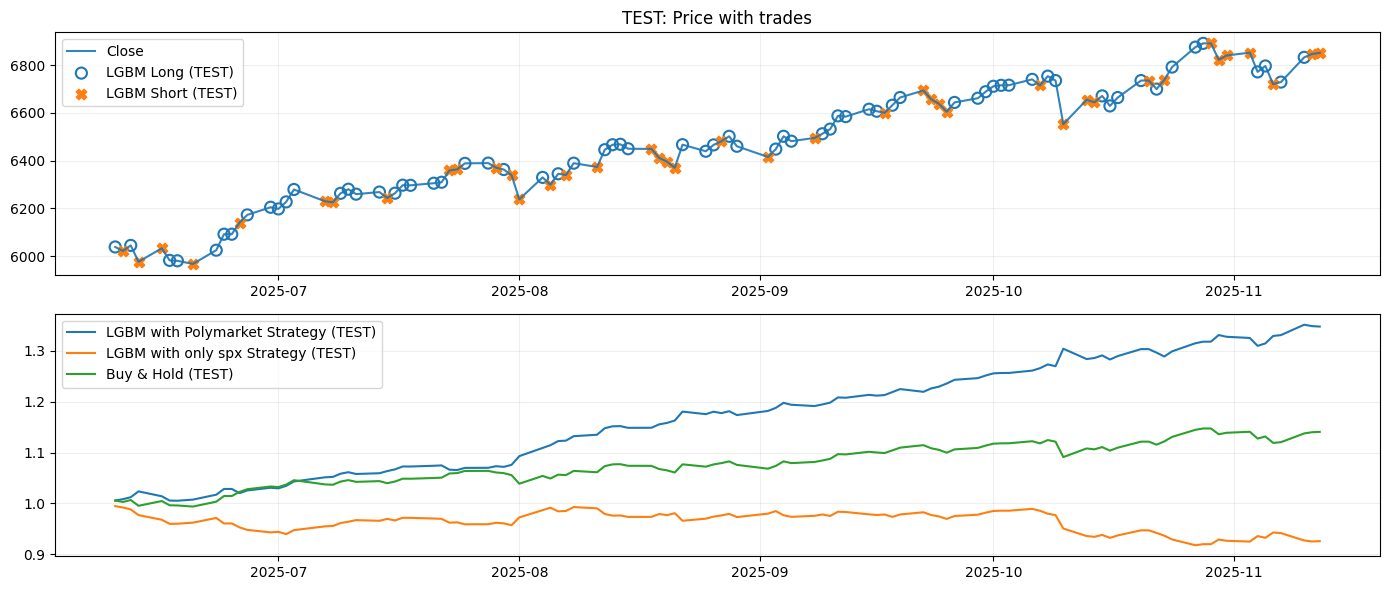

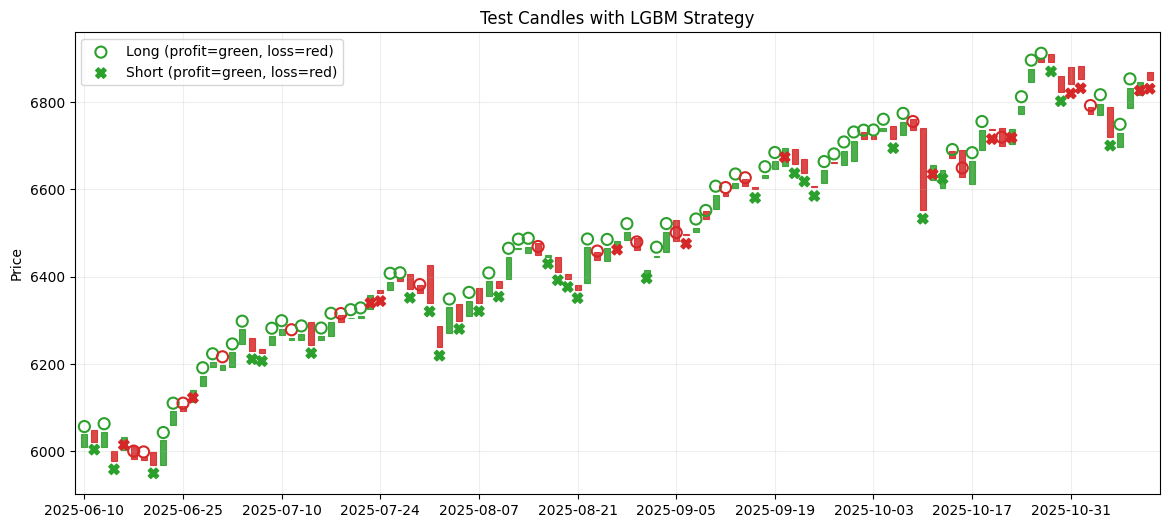

In [23]:
fig, axes = plot_price_and_cumrets(
    poly_df_results,  # full price DataFrame
    idx=poly_test_indices,  # test slice
    price_col='Close',
    trade_specs=[
        {
            'col': 'signal_pred_test',  # your LGBM +1/-1 signal
            'long_val': 1,
            'short_val': -1,
            'long_label': 'LGBM Long (TEST)',
            'short_label': 'LGBM Short (TEST)',
        }
    ],
    curve_specs=[
        {
            'series': poly_cum_tr_lgbm,  # LGBM cumulative returns
            'label': 'LGBM with Polymarket Strategy (TEST)',
        },
        {
            'series': spx_cum_tr_lgbm,  # LGBM cumulative returns
            'label': 'LGBM with only spx Strategy (TEST)',
        },
        {
            'series': cum_tr_bh_test.loc[
                poly_test_indices
            ],  # Buy & Hold cumulative returns
            'label': 'Buy & Hold (TEST)',
        },
    ],
    title_prefix='TEST',
    thresh=None,  # optional, can set if you have a threshold
)

fig, ax, xpos = plot_candles_and_trades(
    data=poly_df_results.copy(),  # only test period
    signal_col='signal_pred_test',
    title="Test Candles with LGBM Strategy",
)

In [24]:
print("Summary statistics for LGBM Strategy (TEST):")
print(f"  Sharpe Ratio polymarket: {sharpe(poly_ret_tr_lgbm):.4f}")
print(f"  Sharpe Ratio spx only: {sharpe(spx_ret_tr_lgbm):.4f}")

Summary statistics for LGBM Strategy (TEST):
  Sharpe Ratio polymarket: 7.2145
  Sharpe Ratio spx only: -1.6430


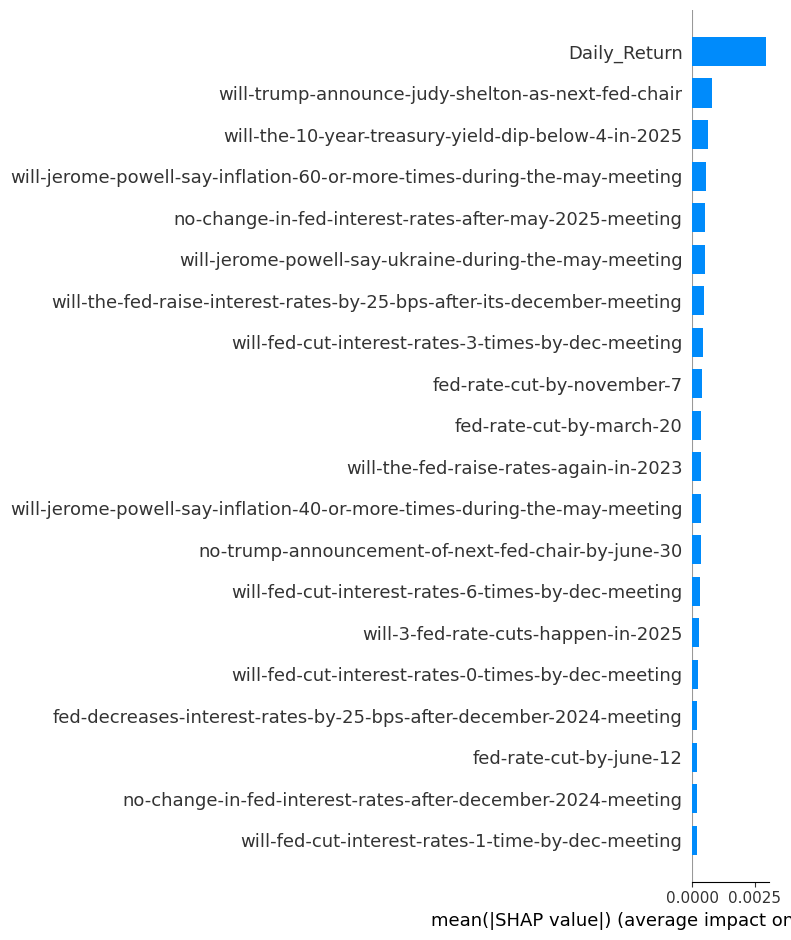

In [ ]:
import shap

# pick some rows to explain (last 200 rows of X_all, or use test_indices)
X_explain = transform_X(test_df)  # X_all.iloc[-200:].copy()

# build SHAP explainer
explainer = shap.TreeExplainer(poly_model)

# compute SHAP values
shap_values = explainer.shap_values(X_explain)

# summary bar plot (global feature importance)
shap.summary_plot(shap_values, X_explain, plot_type="bar")

# Conclusion

Our analysis shows that Polymarket betting data contains genuinely valuable predictive information that can be leveraged to build a profitable and robust trading strategy. Although the raw data is highly unstructured and noisy, our rolling-window LightGBM framework was able to extract stable patterns and produce strong performance. In particular, the model achieved a Sharpe ratio of 7 when trained on Polymarket signals, substantially outperforming the same model applied solely to S&P 500 returns. This suggests that prediction markets capture real-time information and expectations that traditional financial data may reflect more slowly.

However, several important areas require deeper investigation before this strategy can be considered production-ready. First, transaction costs need to be incorporated to understand the impact of turnover on net performance. Second, many Polymarket markets are semantically related and often highly correlated; linking these markets systematically (e.g., by grouping questions across consecutive FOMC meetings) could help reduce noise and improve model structure. Third, experimenting with alternative architectures such as LSTMs or other sequence models may provide better handling of temporal patterns or nonlinear dependencies. Finally, additional work on model stability, regime changes, and out-of-sample robustness will be essential to ensure that the strategy performs reliably under different market conditions.

Overall, the results are promising: Polymarket appears to contain meaningful, tradable signals. With further refinement and validation, this data source has the potential to support a scalable and resilient trading strategy.
